In [96]:
import pandas as pd

df = pd.read_csv("bank-full.csv", sep=";")

features = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
]

df = df[features + ["y"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [97]:
df.y = df.y.map({"yes": 1, "no": 0})

In [98]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [99]:
from sklearn.metrics import roc_auc_score

for x in ['balance', 'day', 'duration', 'previous']:
    y_score = -df_train[x].values if x == 'day' else df_train[x].values
    print(x, ':', roc_auc_score(y_train, y_score))

balance : 0.5899473804882456
day : 0.5266972296878812
duration : 0.8142915057456301
previous : 0.5993297719838377


In [100]:
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_train.shape

(28934, 47)

In [101]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [102]:
dicts = df_val.to_dict(orient='records')
X_val = dv.transform(dicts)

y_pred = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred), 4)

0.8997

In [103]:
import numpy as np

def recall_precision_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['f1'] = 2 * df_scores['precision'] * df_scores['recall'] / (df_scores['precision'] + df_scores['recall'])
    
    return df_scores

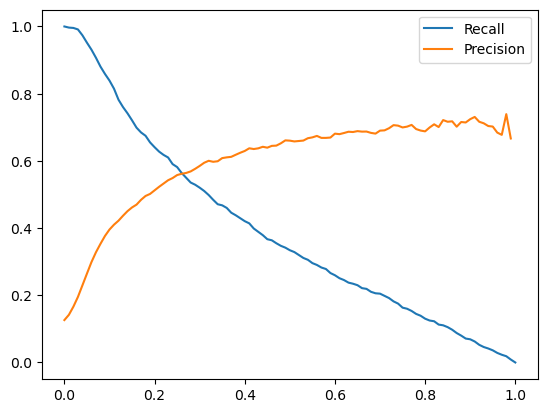

In [104]:
import matplotlib.pyplot as plt

df_scores = recall_precision_dataframe(y_val, y_pred)
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.legend()

In [105]:
df_scores[df_scores['f1'] == df_scores['f1'].max()]

,threshold,tp,fp,fn,tn,recall,precision,f1
23,0.23,557,470,356,5851,0.610077,0.542356,0.574227


In [106]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [109]:
from sklearn.model_selection import KFold

scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print(auc)

print(np.std(scores))


0.9000379998658827
0.8990203131901406
0.9111601569466737
0.9080148800731584
0.91199007106869
0.00549216538339563


In [108]:
C_list = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_list:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(C, '%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

1e-06 0.701 +- 0.009
0.001 0.861 +- 0.007
1 0.906 +- 0.005
